In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')
from src import AFDB_tools, treescore , foldseek2tree
import pandas as pd
import torch

/home/cactuskid/miniconda3/envs/ML2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#load cath dataset from CATH data folder with comment lines as # and white space seperator



domain_df = pd.read_csv('../CATH_data/cath-domain-list.txt' , comment='#' , header = None , delim_whitespace=True)
superfam_df = pd.read_csv('../CATH_data/cath-superfamily-list.txt',  sep='\t' , comment='#' , header = None)
print(domain_df.head())
print(superfam_df.head())

        0   1   2   3   4   5   6   7   8   9   10     11
0  1oaiA00   1  10   8  10   1   1   1   1   1  59    1.0
1  1go5A00   1  10   8  10   1   1   1   1   2  69  999.0
2  3frhA01   1  10   8  10   2   1   1   1   1  58    1.2
3  3friA01   1  10   8  10   2   1   1   1   2  54    1.8
4  3b89A01   1  10   8  10   2   1   1   2   1  54    2.6
           0   1    2                                                  3
0  1.10.8.10  73  318       DNA helicase RuvA subunit, C-terminal domain
1  1.10.8.20   5   24  N-terminal domain of phosphatidylinositol tran...
2  1.10.8.40   2   15                             Albumin-binding domain
3  1.10.8.50  14  543                                                NaN
4  1.10.8.60  60  745                                                NaN


In [4]:
#change the type to string
domain_df = domain_df.astype(str)
domain_df['superfam'] = domain_df[[1,2,3,4]].apply(lambda x : '.'.join(x), axis = 1) 
print(domain_df)

              0  1   2    3   4  5  6  7  8  9  10     11     superfam
0       1oaiA00  1  10    8  10  1  1  1  1  1  59    1.0    1.10.8.10
1       1go5A00  1  10    8  10  1  1  1  1  2  69  999.0    1.10.8.10
2       3frhA01  1  10    8  10  2  1  1  1  1  58    1.2    1.10.8.10
3       3friA01  1  10    8  10  2  1  1  1  2  54    1.8    1.10.8.10
4       3b89A01  1  10    8  10  2  1  1  2  1  54    2.6    1.10.8.10
...         ... ..  ..  ...  .. .. .. .. .. ..  ..    ...          ...
500233  4aybQ00  6  20  450  10  1  1  1  2  1  50    3.2  6.20.450.10
500234  3hkzY00  6  20  450  10  1  1  2  1  1  45    3.4  6.20.450.10
500235  3hkzZ00  6  20  450  10  1  1  2  1  2  45    3.4  6.20.450.10
500236  3zbeA00  6  20  450  20  1  1  1  1  1  71  999.0  6.20.450.20
500237  3duzA04  6  20  460  10  1  1  1  1  1  29   2.95  6.20.460.10

[500238 rows x 13 columns]


                0   1    2                                                  3
0       1.10.8.10  73  318       DNA helicase RuvA subunit, C-terminal domain
1       1.10.8.20   5   24  N-terminal domain of phosphatidylinositol tran...
2       1.10.8.40   2   15                             Albumin-binding domain
3       1.10.8.50  14  543                                                NaN
4       1.10.8.60  60  745                                                NaN
...           ...  ..  ...                                                ...
6626  6.20.430.10   1   14                                                NaN
6627  6.20.440.10   1   10                                                NaN
6628  6.20.450.10   1    4                                                NaN
6629  6.20.450.20   1    1                                                NaN
6630  6.20.460.10   1    1                                                NaN

[6631 rows x 4 columns]


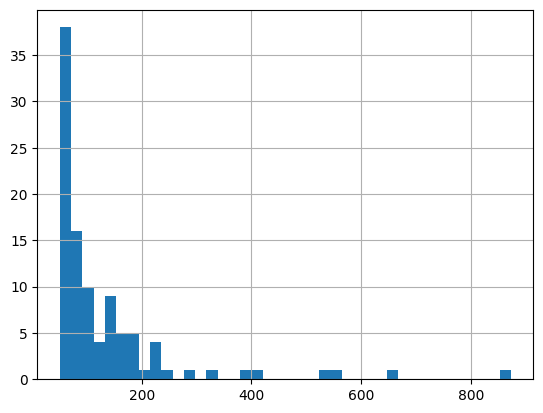

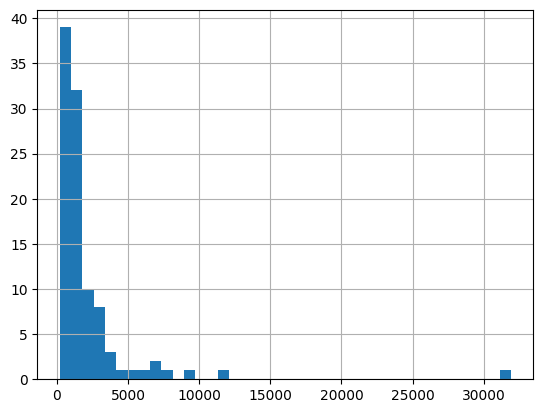

              0  1   2     3   4    5  6  7  8  9  10     11      superfam
0       1oaiA00  1  10     8  10    1  1  1  1  1  59    1.0     1.10.8.10
1       1go5A00  1  10     8  10    1  1  1  1  2  69  999.0     1.10.8.10
2       3frhA01  1  10     8  10    2  1  1  1  1  58    1.2     1.10.8.10
3       3friA01  1  10     8  10    2  1  1  1  2  54    1.8     1.10.8.10
4       3b89A01  1  10     8  10    2  1  1  2  1  54    2.6     1.10.8.10
...         ... ..  ..   ...  ..  ... .. .. .. ..  ..    ...           ...
484682  3wgcA02  3  90  1150  10  194  1  1  1  4  76    2.5  3.90.1150.10
484683  3wgbC02  3  90  1150  10  194  1  1  2  1  83    2.6  3.90.1150.10
484684  3wgbA02  3  90  1150  10  194  1  1  2  2  82    2.6  3.90.1150.10
484685  3wgbD02  3  90  1150  10  194  1  1  2  3  82    2.6  3.90.1150.10
484686  3wgbB02  3  90  1150  10  194  1  1  2  4  77    2.6  3.90.1150.10

[217612 rows x 13 columns]


In [5]:
import matplotlib.pyplot as plt
print( superfam_df)

superfam_df = superfam_df[superfam_df[1] > 50]
superfam_df[1].hist(bins = 40)
plt.show()
superfam_df[2].hist(bins = 40)
plt.show()

domain_df = domain_df[domain_df['superfam'].isin(superfam_df[0])]
print(domain_df)

In [6]:

siftsdf = pd.read_csv('../CATH_data/pdb_chain_cath_uniprot.csv', header=1 )
print(siftsdf)

         PDB CHAIN SP_PRIMARY  CATH_ID
0       101m     A     P02185  101mA00
1       102l     A     P00720  102lA00
2       102m     A     P02185  102mA00
3       103l     A     P00720  103lA00
4       103m     A     P02185  103mA00
...      ...   ...        ...      ...
451315  9xia     A     P24300  9xiaA00
451316  9xim     A     P12851  9ximA00
451317  9xim     B     P12851  9ximB00
451318  9xim     C     P12851  9ximC00
451319  9xim     D     P12851  9ximD00

[451320 rows x 4 columns]


In [7]:
#map CATH_ID of siftsdf to domain_df first column with merge
siftsdf = pd.merge(siftsdf, domain_df, left_on='CATH_ID', right_on=0 , how='right')
print(siftsdf.dropna())




         PDB CHAIN SP_PRIMARY  CATH_ID        0  1   2     3   4    5  6  7  \
0       1oai     A     Q9UBU9  1oaiA00  1oaiA00  1  10     8  10    1  1  1   
1       1go5     A     Q9UBU9  1go5A00  1go5A00  1  10     8  10    1  1  1   
2       3frh     A     Q763K9  3frhA01  3frhA01  1  10     8  10    2  1  1   
3       3fri     A     Q763K9  3friA01  3friA01  1  10     8  10    2  1  1   
4       3b89     A     Q763K9  3b89A01  3b89A01  1  10     8  10    2  1  1   
...      ...   ...        ...      ...      ... ..  ..   ...  ..  ... .. ..   
219410  3wgc     A     O07051  3wgcA02  3wgcA02  3  90  1150  10  194  1  1   
219411  3wgb     C     O07051  3wgbC02  3wgbC02  3  90  1150  10  194  1  1   
219412  3wgb     A     O07051  3wgbA02  3wgbA02  3  90  1150  10  194  1  1   
219413  3wgb     D     O07051  3wgbD02  3wgbD02  3  90  1150  10  194  1  1   
219414  3wgb     B     O07051  3wgbB02  3wgbB02  3  90  1150  10  194  1  1   

        8  9  10     11      superfam  
0       1  

In [8]:
print(siftsdf.superfam.unique(),len(siftsdf.superfam.unique()))

['1.10.8.10' '1.10.8.60' '1.10.10.10' '1.10.10.60' '1.10.150.20'
 '1.10.150.50' '1.10.238.10' '1.10.260.40' '1.10.357.10' '1.10.490.10'
 '1.10.510.10' '1.10.533.10' '1.10.600.10' '1.10.630.10' '1.10.760.10'
 '1.20.5.170' '1.20.1050.10' '1.20.1260.10' '1.25.10.10' '1.25.40.10'
 '1.25.40.20' '2.10.25.10' '2.10.70.10' '2.30.29.30' '2.30.30.40'
 '2.30.30.100' '2.30.30.140' '2.30.42.10' '2.30.110.10' '2.40.10.10'
 '2.40.30.10' '2.40.50.40' '2.40.50.100' '2.40.50.140' '2.40.128.20'
 '2.60.40.10' '2.60.40.420' '2.60.40.1180' '2.60.120.10' '2.60.120.20'
 '2.60.120.200' '2.60.120.260' '2.80.10.50' '2.130.10.10' '3.10.20.90'
 '3.10.100.10' '3.10.129.10' '3.10.180.10' '3.10.450.50' '3.20.20.70'
 '3.20.20.80' '3.20.20.120' '3.20.20.140' '3.30.40.10' '3.30.70.100'
 '3.30.70.270' '3.30.70.330' '3.30.160.60' '3.30.200.20' '3.30.360.10'
 '3.30.390.10' '3.30.420.10' '3.30.420.40' '3.30.450.20' '3.30.450.40'
 '3.30.470.20' '3.30.505.10' '3.30.530.20' '3.30.930.10' '3.40.30.10'
 '3.40.47.10' '3.40.50.150

In [11]:
from src import AFDB_tools
import os
datapath = '../CATH_data/'
nprots = 500
#iterate over all superfamilies and create a tree for each
for superfam in siftsdf.superfam.unique():
    #create a tree for each superfam
    #sample 1000 proteins from the superfam
    sub = siftsdf[siftsdf.superfam == superfam]
    prots = sub.sample(min(nprots, len(sub))).dropna()
    print(prots)

    #output the sequence dataset to a file
    prots.to_csv(datapath+superfam+'/sequence_dataset.csv')
    #create a folder for the superfam if it does not exist

    if not os.path.exists(datapath+superfam):
        os.mkdir(datapath+superfam)
    
    #output the uniport ids to a file
    with open(datapath+superfam+'/identifiers.txt', 'w') as f:
        f.write('\n'.join( list(prots['SP_PRIMARY'])))

      PDB CHAIN SP_PRIMARY  CATH_ID        0  1   2  3   4   5  6  7  8   9  \
316  2dna     A     Q14DL0  2dnaA00  2dnaA00  1  10  8  10  70  1  1  1   1   
160  2h5x     C     P9WGW3  2h5xC03  2h5xC03  1  10  8  10  26  1  1  1   2   
92   2ztd     A     P9WGW3  2ztdA03  2ztdA03  1  10  8  10  19  1  1  1   1   
124  2hak     H     Q9P0L2  2hakH03  2hakH03  1  10  8  10  20  3  1  1   1   
34   2bwb     B     P48510  2bwbB00  2bwbB00  1  10  8  10  10  1  1  2   5   
..    ...   ...        ...      ...      ... ..  .. ..  ..  .. .. .. ..  ..   
281  2lvq     D     Q9UKV5  2lvqD00  2lvqD00  1  10  8  10  47  1  1  1   4   
83   6if1     B     P61086  6if1B02  6if1B02  1  10  8  10  17  1  1  1   6   
113  2wzj     D     O08679  2wzjD03  2wzjD03  1  10  8  10  20  2  1  1  10   
82   6if1     A     P61086  6if1A02  6if1A02  1  10  8  10  17  1  1  1   5   
313  2dzl     A     Q8IYN6  2dzlA00  2dzlA00  1  10  8  10  68  1  1  1   1   

     10     11   superfam  
316  67  999.0  1.10.8.